#About
This notebook is part of the summary of my field experience supported by Ally Financial Company, as well as a nice chance to practice what I learnt from the course STOR445 Stochastic Modeling in the semester Spring2023.

I came across a post on HN and saw a great intro of GPT as a finite-state markov chain. The reviews below are also inspiring. Here are the related links:

https://colab.research.google.com/drive/1SiF0KZJp75rUeetKOWqpsA8clmHP6jMg?usp=sharing#scrollTo=mGHwSuHQuTXI

https://news.ycombinator.com/item?id=35506069

What in below aims to see what MC looks like when both vocab size and content length are 2, as well as get familiar with the code.


In [ ]:
# hyperparameters for our GPT

# vocab size is 2, so we only have two possible tokens: 0,1
vocab_size = 2
# context length is 2, so we take 2 bits to predict the next bit probability
context_length = 2

In [ ]:
print('state space (for this exercise) = ', vocab_size ** context_length)

state space (for this exercise) =  4


In [ ]:
print('actual state space (in reality) = ', sum(vocab_size ** i for i in range(1, context_length+1)))

actual state space (in reality) =  6


The input to the GPT neural net is a sequence of tokens of length
`context_length`. These tokens are discrete, so the state space is simply:(00) (01) (10) (11).

If the context length is 2, we could in principle feed in 1 token or 2 tokens when trying to predict the next token. Here we are going to ignore this and assume that the context length is "maxed out" (which means we just talk about 2 tokens), just to simplify some of the code below, but this is worth keeping in mind.

In [ ]:
#@title minimal GPT implementation in PyTorch (optional)
""" super minimal decoder-only gpt """

import math
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F

torch.manual_seed(1337)

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                    .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k ,v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # manual implementation of attention
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.c_proj(y)
        return y

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.nonlin = nn.GELU()

    def forward(self, x):
        x = self.c_fc(x)
        x = self.nonlin(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    # these are default GPT-2 hyperparameters
    block_size: int = 1024
    vocab_size: int = 50304
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    bias: bool = False

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %d" % (sum(p.nelement() for p in self.parameters()),))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (1, t, n_embd)
        x = tok_emb + pos_emb
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x[:, -1, :]) # note: only returning logits at the last time step (-1), output is 2D (b, vocab_size)
        return logits



In [ ]:
config = GPTConfig(
    block_size = context_length,
    vocab_size = vocab_size,
    n_layer = 4,
    n_head = 4,
    n_embd = 16,
    bias = False,
)
gpt = GPT(config)

number of parameters: 12640


In [ ]:
def all_possible(n, k):
    # return all possible lists of k elements, each in range of [0,n)
    if k == 0:
        yield []
    else:
        for i in range(n):
            for c in all_possible(n, k - 1):
                yield [i] + c
list(all_possible(vocab_size, context_length))

[[0, 0], [0, 1], [1, 0], [1, 1]]

input [0, 0] ---> [0.5834338068962097, 0.4165661931037903]
input [0, 1] ---> [0.4045574963092804, 0.5954424738883972]
input [1, 0] ---> [0.5810206532478333, 0.418979287147522]
input [1, 1] ---> [0.40443000197410583, 0.5955699682235718]


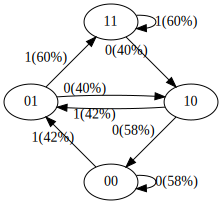

In [ ]:
# we'll use graphviz for pretty plotting the current state of the GPT
from graphviz import Digraph

def plot_model():
    dot = Digraph(comment='Baby GPT', engine='circo')

    for xi in all_possible(gpt.config.vocab_size, gpt.config.block_size):

        # forward the GPT and get probabilities for next token
        x = torch.tensor(xi, dtype=torch.long)[None, ...] # turn the list into a torch tensor and add a batch dimension
        logits = gpt(x) # forward the gpt neural net
        probs = nn.functional.softmax(logits, dim=-1) # get the probabilities
        y = probs[0].tolist() # remove the batch dimension and unpack the tensor into simple list
        print(f"input {xi} ---> {y}")

        # also build up the transition graph for plotting later
        current_node_signature = "".join(str(d) for d in xi)
        dot.node(current_node_signature)
        for t in range(gpt.config.vocab_size):
            next_node = xi[1:] + [t] # crop the context and append the next character
            next_node_signature = "".join(str(d) for d in next_node)
            p = y[t]
            label=f"{t}({p*100:.0f}%)"
            dot.edge(current_node_signature, next_node_signature, label=label)

    return dot

plot_model()

We see our 4 states, and the probabilistic arrows that connect them. Because there are 2 possible tokens, there are 2 possible arrows coming out of each node. Note that every time we "transition" via an edge, the leftmost token gets dropped, and the token on that edge gets appended to the right. Notice that at initialization, most of these probabilities are around uniform (50% in this case), which is nice and desirable, as we haven't even trained the model at all.

In [ ]:
# let's train our baby GPT on this sequence
seq = list(map(int, "111101111011110"))
seq

[1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0]

In [ ]:
# convert the sequence to a tensor holding all the individual examples in that sequence
X, Y = [], []
# iterate over the sequence and grab every consecutive 3 bits
# the correct label for what's next is the next bit at each position
for i in range(len(seq) - context_length):
    X.append(seq[i:i+context_length])
    Y.append(seq[i+context_length])
    print(f"example {i+1:2d}: {X[-1]} --> {Y[-1]}")
X = torch.tensor(X, dtype=torch.long)
Y = torch.tensor(Y, dtype=torch.long)
print(X.shape, Y.shape)

example  1: [1, 1] --> 1
example  2: [1, 1] --> 1
example  3: [1, 1] --> 0
example  4: [1, 0] --> 1
example  5: [0, 1] --> 1
example  6: [1, 1] --> 1
example  7: [1, 1] --> 1
example  8: [1, 1] --> 0
example  9: [1, 0] --> 1
example 10: [0, 1] --> 1
example 11: [1, 1] --> 1
example 12: [1, 1] --> 1
example 13: [1, 1] --> 0
torch.Size([13, 2]) torch.Size([13])


In [ ]:
# init a GPT and the optimizer
torch.manual_seed(1337)
gpt = GPT(config)
optimizer = torch.optim.AdamW(gpt.parameters(), lr=1e-3, weight_decay=1e-1)

number of parameters: 12640


In [ ]:
# train the GPT for some number of iterations
for i in range(50):
    logits = gpt(X)
    loss = F.cross_entropy(logits, Y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(i, loss.item())

0 0.6616935133934021
1 0.6317402124404907
2 0.6050006747245789
3 0.5929291248321533
4 0.5903751254081726
5 0.587951123714447
6 0.5842908620834351
7 0.5807065367698669
8 0.577465295791626
9 0.5744820833206177
10 0.571670651435852
11 0.5689849257469177
12 0.5664036273956299
13 0.5639188885688782
14 0.5615299344062805
15 0.5592407584190369
16 0.5570589900016785
17 0.5549943447113037
18 0.5530572533607483
19 0.5512576699256897
20 0.5496029257774353
21 0.5480983257293701
22 0.5467461943626404
23 0.5455450415611267
24 0.5444915890693665
25 0.5435795187950134
26 0.5428012609481812
27 0.5421478152275085
28 0.5416089296340942
29 0.5411741733551025
30 0.5408323407173157
31 0.5405718684196472
32 0.5403817296028137
33 0.5402498841285706
34 0.5401651859283447
35 0.540116012096405
36 0.5400907397270203
37 0.5400779843330383
38 0.5400656461715698
39 0.5400412082672119
40 0.5399907231330872
41 0.5398979783058167
42 0.539743185043335
43 0.5394999980926514
44 0.5391327142715454
45 0.5385890007019043
46 

Training data sequence, as a reminder: [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0]
input [0, 0] ---> [0.21870099008083344, 0.7812989950180054]
input [0, 1] ---> [0.2317209243774414, 0.7682790756225586]
input [1, 0] ---> [0.21896907687187195, 0.7810309529304504]
input [1, 1] ---> [0.25789374113082886, 0.7421062588691711]


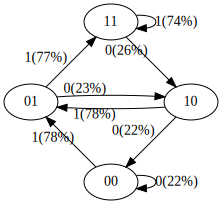

In [ ]:
print("Training data sequence, as a reminder:", seq)
plot_model()

The arrows that correspond to transitions in our training data get higher probabilities. That makes sense. For example:

In our training data 10 always transitions to 01. After 50 steps of training, we see that this transition has 78% probability. Inversely 01 hardly transfer to 10 in the training data so the prob is relatively low (23%).

The states 00 that never appeared in the training data has substantial probabilities(22%) for what tokens should come next. This is desirable because in a real application scenario during deployment, almost every test input to the GPT is a never-before-seen input during training. We rely on the internals of the GPT (and its "inductive bias") to perform the generalization appropriately.



In [ ]:
xi = [1, 1] # the starting sequence
fullseq = xi.copy()
print(f"init: {xi}")
for k in range(20):
    x = torch.tensor(xi, dtype=torch.long)[None, ...]
    logits = gpt(x)
    probs = nn.functional.softmax(logits, dim=-1)
    t = torch.multinomial(probs[0], num_samples=1).item() # sample from the probability distribution
    xi = xi[1:] + [t] # transition to the next state
    fullseq.append(t)
    print(f"step {k}: state {xi}")

print("\nfull sampled sequence:")
print("".join(map(str, fullseq)))

init: [1, 1]
step 0: state [1, 1]
step 1: state [1, 1]
step 2: state [1, 1]
step 3: state [1, 1]
step 4: state [1, 1]
step 5: state [1, 1]
step 6: state [1, 1]
step 7: state [1, 0]
step 8: state [0, 0]
step 9: state [0, 1]
step 10: state [1, 0]
step 11: state [0, 1]
step 12: state [1, 1]
step 13: state [1, 1]
step 14: state [1, 0]
step 15: state [0, 0]
step 16: state [0, 1]
step 17: state [1, 1]
step 18: state [1, 1]
step 19: state [1, 1]

full sampled sequence:
1111111110010111001111


Depending on how much you train your network, these sequences will look more and more like the training data. In our case we'd never get a perfect match because the state 11 has an ambiguous future: 50% of the time it's 1, 50% time a 0.